# **Machine Learning II: Deep learning classifiers for urban sound data**
<img src="https://github.com/alfredofdlv/MCII-Project/blob/main_alfredo/images/portrait.png?raw=1" alt="Portrait" style="width:100%; height:auto;">

===================================================================================================================


## **Introduction**
Urban sound recognition is a crucial component in the development of intelligent systems for cities, supporting applications in public safety, environmental monitoring, and transportation. This project focuses on designing and evaluating deep learning classifiers for recognizing urban sounds using the UrbanSound8K dataset. This dataset contains audio samples across 10 classes commonly found in urban environments, such as "siren," "dog bark," and "street music." To address the classification challenge, we implement two neural network architectures: a **Recurrent Neural Network (RNN)**, which leverages temporal patterns in audio data, and a **Convolutional Neural Network (CNN)**, which captures spatial features within spectrogram representations of audio. By comparing these models, we aim to identify which architecture is more effective in urban sound classification tasks, balancing accuracy, computational efficiency, and model complexity.


### **Abstract**

This project presents a deep learning approach for urban sound classification, utilizing the UrbanSound8K dataset to train and evaluate two neural network models: a **Recurrent Neural Network (RNN)** and a **Convolutional Neural Network (CNN)**. Our data preparation pipeline applies comprehensive preprocessing steps, including signal normalization and feature extraction, to transform raw audio signals into structured representations suitable for deep learning input. Model architectures are iteratively optimized through adjustment of layer configurations, activation functions, and hyperparameters to enhance performance.

Training strategies included empirical(due to computational reasons)fine-tuning of optimizers and regularization techniques, alongside a robust **10-fold cross-validation** to assess generalization. Classification performance is evaluated based on accuracy and the confusion matrix across folds, providing insights into each model's strengths in handling distinct sound classes.

### **Objective of the work**
The primary objective of this project is to develop and assess the efficacy of two distinct neural network architectures—RNN and CNN—for urban sound classification. By conducting a comparative analysis, we aim to provide understanding of each model's performance, identifying the trade-offs in accuracy, computational demands, and architectural complexity.

### **Structure of the work**
The project is structured into the following sections:

1. **Data pre-processing and preparation**: This section outlines the steps taken to preprocess the UrbanSound8K dataset. It includes methods for converting audio data into suitable features for the RNN and CNN models, specifically focusing on Mel-Frequency Cepstral Coefficients (MFCCs) for the RNN, which capture temporal patterns, and spectrograms for the CNN, which enable spatial feature extraction.
2. **Model Architectures**: A detailed description of the RNN and CNN models.
    - *RNN Architecture*: Explores the sequential processing layers of the RNN and includes comparisons of different submodels like LSTM and GRU, which capture temporal dependencies in audio features.
    - *CNN Architecture*: Describes the structure of the CNN model.
    - *Training Strategies*: This section discusses the training approaches used for both models, including optimizers, regularization techniques, and adjustments for each model architecture.
    - *Evaluation Metrics*:  A description of the metrics used to evaluate model performance, including accuracy and confusion matrices.
5. **Deep Fool Strategy**: This section describes the use of the DeepFool algorithm to evaluate the robustness of the trained models against adversarial perturbations.
6. **Results and Discussion**: A presentation of the results obtained from the models, comparing the effectiveness of the RNN and CNN architectures.

## **Data pre-processing and preparation**

In [9]:
######## LIBRARIES ###############
import soundata
import librosa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from importlib import reload
import utils
import pickle
import random
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from visualizations import analyze_audio_features


### **Importing the data**

The UrbanSound8K Dataset contains 8,732 labeled sound clips (≤4 seconds each) spanning 10 urban sound classes: air conditioner, car horn, children playing, dog bark, drilling, engine idling, gun shot, jackhammer, siren, and street music. These classes represent a taxonomy of urban sounds, and each audio file is derived from field recordings uploaded to Freesound.org. Files are organized into ten predefined folds (fold1-fold10) for reproducibility and comparability of classification results.

Via the `soundata` library, in addition to the audio files in WAV format, a CSV metadata file, *UrbanSound8k.csv*, is provided. Key metadata includes:

- slice_file_name: Audio filename
- fsID: Original Freesound ID.
- start and end: Time range of the slice within the original recording.
- salience: Subjective salience rating (1 = foreground, 2 = background).
- fold: Predefined fold assignment (1-10).
- classID: Numeric class identifier (0-9).
- class: Name of the sound class.

We will also perform ***Exploratory Data Analysis(EDA)*** and data visualizations.

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIR = r'D:\Python_D\DeepLearningAudios'
dataset = soundata.initialize('urbansound8k', data_home = DATA_DIR)

metadata = pd.read_csv(os.path.join(DATA_DIR,"metadata","UrbanSound8k.csv"))
print(metadata.head(4))

# Display basic information
print("Dataset Info:")
metadata.info()
# Check for missing values
print("\nChecking for missing values:")
print(metadata.isnull().sum())


      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID         

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_6196\2494736104.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='fold', palette='viridis')
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_6196\2494736104.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='class', order=d

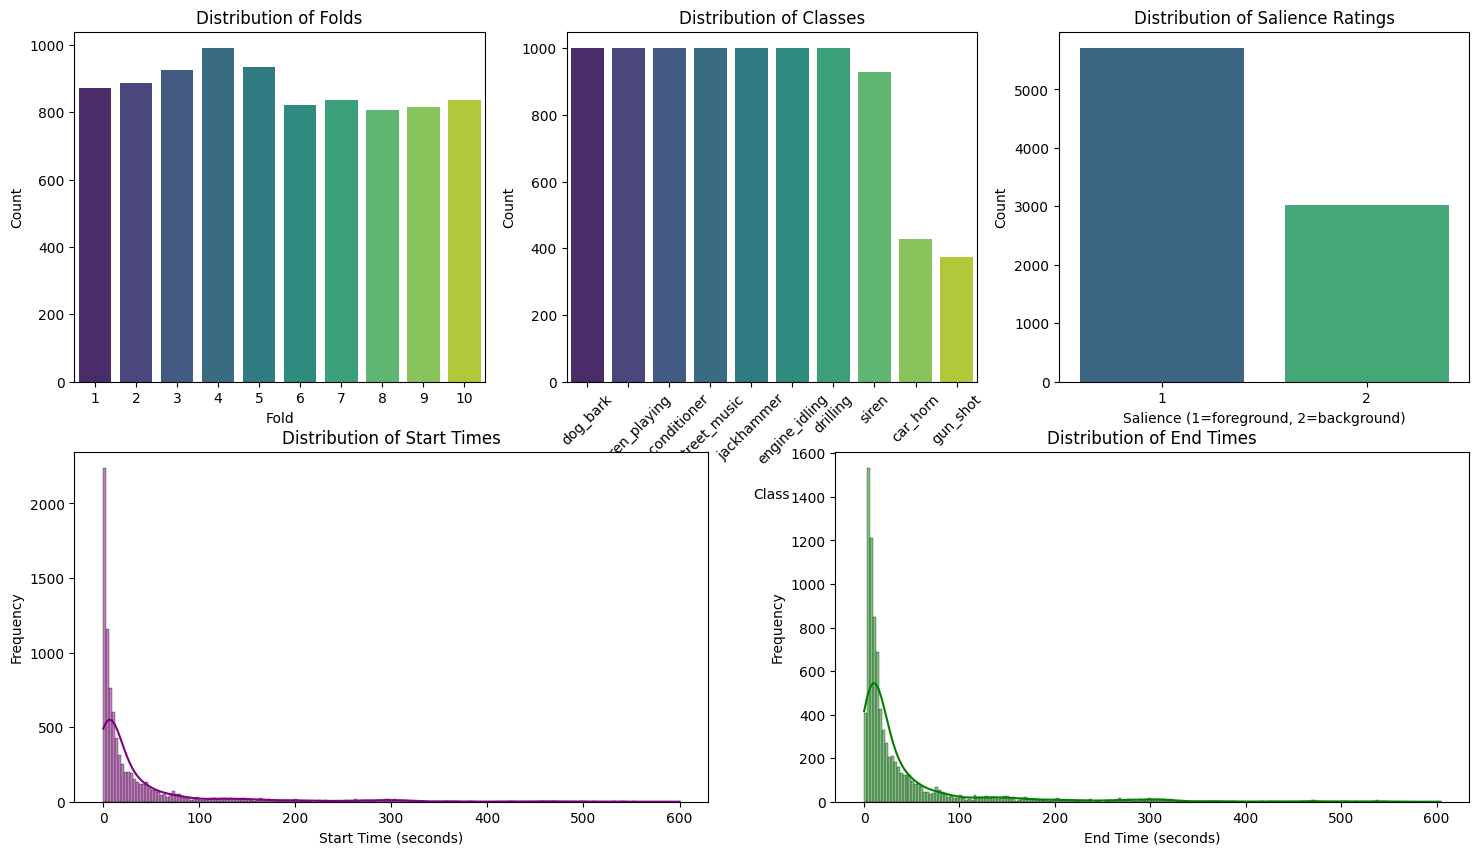

In [6]:
data = metadata


# Create a figure with a grid of subplots
plt.figure(figsize=(18, 10))

# Plot 1: Distribution of Folds
plt.subplot(2, 3, 1)
sns.countplot(data=data, x='fold', palette='viridis')
plt.title("Distribution of Folds")
plt.xlabel("Fold")
plt.ylabel("Count")

# Plot 2: Distribution of Classes
plt.subplot(2, 3, 2)
sns.countplot(data=data, x='class', order=data['class'].value_counts().index, palette='viridis')
plt.xticks(rotation=45)
plt.title("Distribution of Classes")
plt.xlabel("Class")
plt.ylabel("Count")

# Plot 3: Distribution of Salience Ratings
plt.subplot(2, 3, 3)
sns.countplot(data=data, x='salience', palette='viridis')
plt.title("Distribution of Salience Ratings")
plt.xlabel("Salience (1=foreground, 2=background)")
plt.ylabel("Count")

# Plot 4: Histogram of Start Times
plt.subplot(2, 2, 3)  # Adjusted for 2x2 grid starting from position 3
sns.histplot(data['start'], kde=True, color='purple')
plt.title("Distribution of Start Times")
plt.xlabel("Start Time (seconds)")
plt.ylabel("Frequency")

# Plot 5: Histogram of End Times
plt.subplot(2, 2, 4)  # Position adjusted for the last plot
sns.histplot(data['end'], kde=True, color='green')
plt.title("Distribution of End Times")
plt.xlabel("End Time (seconds)")
plt.ylabel("Frequency")

# Adjust layout to prevent overlap and add space between rows
plt.tight_layout()

plt.show()


In the dataset, as observed from the plots and summary statistics above, there are no missing data values. Additionally, the distribution of samples across the folds is relatively uniform, which supports balanced cross-validation. However, we do observe a class imbalance, particularly in the underrepresentation of the *car horn* and *gunshot* classes. Furthermore, a substantial portion of the data is labeled as foreground sounds, indicating that most audio samples have been annotated as prominent in the scene.

In [ ]:

# Agrupar datos por 'fold' y 'class' para contar el número de muestras
fold_class_counts = data.groupby(['fold', 'class']).size().unstack(fill_value=0)

# Configuración del gráfico de barras apiladas
plt.figure(figsize=(12, 8))
fold_class_counts.plot(
    kind='bar', 
    stacked=True, 
    colormap='tab20', 
    width=0.8, 
    edgecolor='black',
    ax=plt.gca()
)

# Añadir título y etiquetas a los ejes
plt.title("Class Distribution Across Folds", fontsize=16)
plt.xlabel("Fold", fontsize=14)
plt.ylabel("Sample Count", fontsize=14)

# Añadir leyenda para identificar las clases
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

![classdistracrossfold](images/class_distr_accross_folds.png)

To evaluate whether the classes are similarly distributed across folds, we can perform a hypothesis test of independence. This test will determine if there is a significant association between the variables fold and class, indicating whether the class distributions vary across folds. Chi-square test of independence :

- ($H_o$): The class distribution is the same across all folds (i.e., there is no association between fold and class).
- ($H_1$): The class distribution is not the same across folds (there is an association between fold and class).

In [44]:
import scipy.stats as stats

contingency_table = pd.crosstab(data['fold'], data['class'])
# Perform the Chi-square test of independence
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print("Chi-square:", chi2)
print("Degrees of freedom:", dof)
print("P-value:", p)
# Interpret the result
alpha = 0.05
if p < alpha:
    print("We reject the null hypothesis: the class distribution differs across folds.")
else:
    print("We do not reject the null hypothesis: there is no significant evidence that the class distribution differs across folds.")

Chi-square: 192.2425218659076
Degrees of freedom: 81
P-value: 4.920225559810079e-11
We reject the null hypothesis: the class distribution differs across folds.


Since the p-value is extremely small, we have strong evidence to **reject the null hypothesis**. This means that the class distribution is not uniform across the folds. In other words, some folds may have an overrepresentation or underrepresentation of certain classes, which could affect the fairness of model evaluation.This class imbalance across folds can lead to skewed performance metrics, where certain folds may have an overrepresentation or underrepresentation of particular classes, impacting the model's ability to generalize effectively, as mentioned in the original paper of *Justin Salomon*.

Analyzing the performance of audio classification models across **foreground (FG) and background (BG)** labels provides valuable insights into their strengths and limitations. In the UrbanSound8K dataset, sound instances are labeled both by class and salience: FG sounds are prominent and easily distinguishable, while BG sounds often overlap with other audio sources or are less perceptually salient. 

This distinction is particularly significant because real-world audio classification is inherently noisy. Features like Mel-Frequency Cepstral Coefficients (MFCCs), commonly used in audio modeling, are highly sensitive to background noise and distortions. As a result, models relying on such features may perform better on FG-labeled samples, where the target sound is more isolated, compared to BG-labeled samples, which often involve overlapping or diffuse sounds. Investigating these differences can help us better understand the interplay between salience and model performance.

By examining FG and BG performance separately, we can pinpoint specific challenges, such as a model’s inability to generalize under noisy or complex conditions. These insights can inform the development of more robust algorithms. Advanced techniques like **DeepFool algorithms will be later on explored to evaluate classification in challenging BG scenarios**.

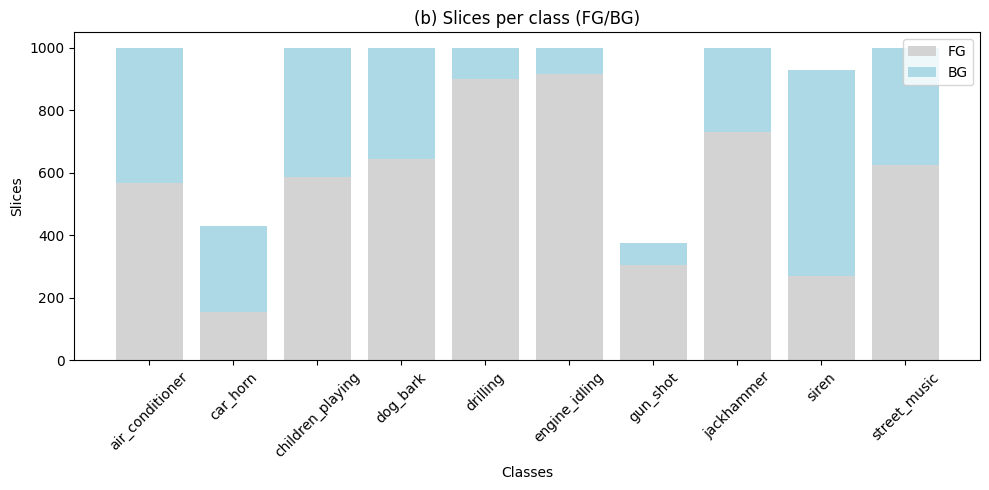

In [2]:
from visualizations import plot_urban_sound_slices
plot_urban_sound_slices()

### **Feature Extraction**

For our work with deep learning models, extracting relevant audio features is essential to ensure that the model receives inputs that can be effectively processed. According to `librosa` documentation, a specialized library for audio analysis, and the audio analysis papers mentioned in the bibliography, we decided to extract the low and high level spectral audio features:

- **Waveform**: The waveform is a simple representation of sound that captures the amplitude of an audio signal over time. While basic, it provides essential insight into the raw dynamics of the audio signal.

- **Zero Crossing Rate (ZCR)**: The Zero Crossing Rate measures how frequently the audio signal crosses the zero axis within a specified period. This feature is useful for detecting sudden changes in the signal's spectral characteristics.

- **Root Mean Square Energy (RMSE)**: RMSE calculates the quadratic mean of the energy in each frame of the audio signal. It is particularly useful for understanding variations in volume and intensity over time.

- **Mel-Frequency Cepstral Coefficients (MFCCs)**: MFCCs are derived from the spectrogram and are designed to model the human auditory system. These coefficients compress the audio data while preserving its most perceptually significant features. Widely used in audio and signal proccesing. First and second order deltas are also included.

- **Spectral Centroid**: The spectral centroid represents the weighted average of the frequencies in the spectrum of an audio signal. It indicates where the majority of the spectral energy is concentrated, which correlates with the perceived brightness of the sound.

- **Spectral Bandwidth**: This feature measures the width of the frequency spectrum around the spectral centroid. It is helpful for distinguishing between complex sounds, such as noise, and more tonal sounds with a clear harmonic structure.

- **Spectral Rolloff**: Spectral rolloff marks the frequency below which a specified portion of the total spectral energy is contained. This feature is valuable for distinguishing between sharp, sudden sounds and steady, continuous ones, aiding in the classification of different types of audio events.

- **Mel Spectrogram**: A Mel spectrogram is a visual representation that illustrates how the frequency components of an audio signal change over time. It uses the Mel scale, which aligns more closely with human auditory perception

***Disclaimer: All features where extracted with the parameters used in the original Salomon´s paper*.**

A visual representation sample is shown below. 




d:\Python_D\DeepLearningAudios\MCII-Project\.venv\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


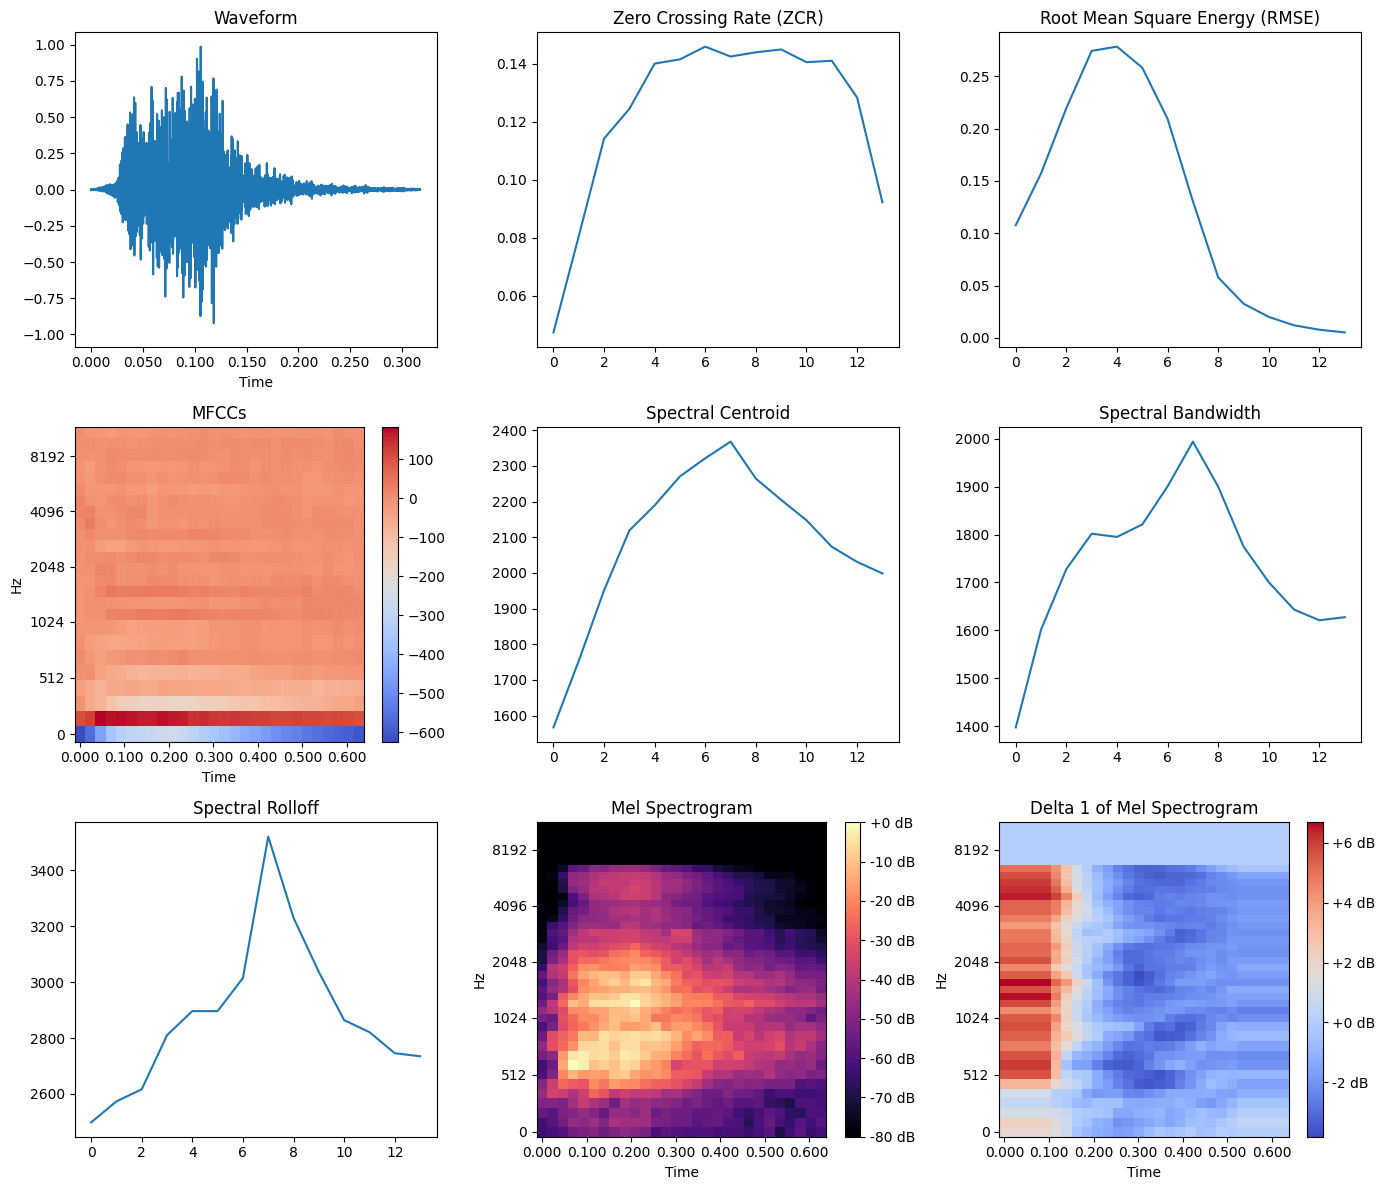

In [2]:
from visualizations import analyze_audio_features
import os
# Audio path file
DATA_DIR = r"D:\Python_D\DeepLearningAudios"
dir_audio_example = os.path.join(DATA_DIR, "audio", "fold5", "100032-3-0-0.wav")
analyze_audio_features(dir_audio_example)


After extracting the spectral features from the audio data, a post-processing step was performed. Specifically, it is important to note that not all features return arrays of the same length. Three main approaches could have been considered for addressing this issue:

**1. Padding the arrays:** This method extends shorter feature arrays by adding zeros or other padding values to achieve a uniform length. The advantage of this approach is that it ensures all feature arrays are of the same size, facilitating batch processing without data loss. However, the main disadvantage is that padding can introduce artificial data, which might degrade model performance, particularly when the padding significantly exceeds the actual signal length.

**2. Truncating the arrays to a minimum length:** This method involves cutting all feature arrays down to a predefined minimum length. The advantage is that it reduces the computational overhead and focuses on the most relevant parts of the signal. On the downside, truncation may discard important information, especially if the truncated portion of the signal contains critical acoustic features that are necessary for accurate classification.

**3. Repetition of the same sound to complete the 4-second length:** In this approach, the audio signal is repeated until it reaches the desired duration. The advantage is that it preserves the integrity of the original data, ensuring that feature arrays are consistent in length without discarding any part of the signal. However, the disadvantage is that repeating the same sound may introduce redundancy, which could negatively affect model generalization if the repeated sound is not representative of the full data distribution.

Each of these methods has its trade-offs in terms of data integrity, computational efficiency, and model performance. Finally, empirically, we decided that for the RNN we would opt for sound repetition, as it yielded better results, while for the CNN, a mix of repetition and padding would be used depending on the array length. Below is an illustration of a dog bark, and how this repetition process is calculated.

File D:\Python_D\DeepLearningAudios\audio\fold10\102103-3-0-0.wav saved at sounds


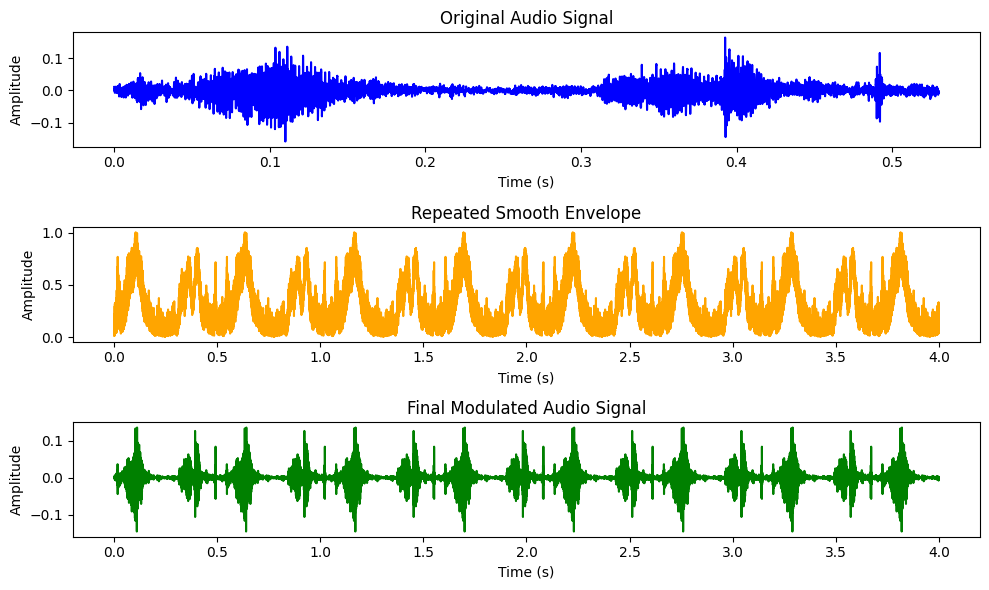

In [19]:
import os
from visualizations import repeat_audio_envelope

DATA_DIR = r"D:\Python_D\DeepLearningAudios"
sound =  "102103-3-0-0.wav"
dir_audio_example = os.path.join(DATA_DIR, "audio", "fold10",sound)
repeat_audio_envelope(dir_audio_example)


The envelope was calculated by taking the absolute value of the sound signal, then applying harmonic enhancement to smooth it. After that, the envelope was normalized so that its maximum value was 1.

**When extracting the vector with all features from the audio, if more than one feature is present, what we do is repeat the entire feature vector until the desired duration is reached. In this case, the audio signal and its envelope were repeated until they filled 4 seconds, ensuring that the length of the feature array was consistent across samples.**

In [20]:
import os
from IPython.display import Audio

sounds_folder_path = "sounds"

repeated_full_path = os.path.join(sounds_folder_path, sound)
Audio(repeated_full_path)


# **Model Architectures**
## **Recurrent Neural Networks**

**Recurrent Neural Networks (RNNs)** are a class of artificial neural network architectures designed to process sequential data by leveraging feedback loops within the network. Unlike traditional feedforward neural networks, where information flows unidirectionally from input to output without any form of memory, RNNs are specifically designed to retain information over time. This is achieved through cyclic connections, which allow information to persist across time steps, enabling the network to model temporal dependencies and contextual relationships within sequences effectively.

The ability of RNNs to maintain an internal state through feedback mechanisms enables them to capture long-range dependencies, which is particularly useful in tasks such as speech recognition, natural language processing, and time series forecasting. By maintaining a memory of previous inputs, RNNs can use this historical context to inform predictions about future steps in the sequence. However, traditional RNNs face challenges in learning long-term dependencies due to issues such as vanishing and exploding gradients, which can hinder their ability to model longer sequences effectively.

To address these limitations, more advanced variants of RNNs, such as **Long Short-Term Memory (LSTM) networks and Gated Recurrent Units (GRUs)**, have been developed. Both LSTMs and GRUs introduce specialized mechanisms to regulate the flow of information, allowing the networks to retain and forget information more effectively across long sequences. LSTMs use a set of gates (input, forget, and output gates) to control the cell state, while GRUs combine these gates into a simpler architecture with reset and update gates. These improvements have made LSTM and GRU networks particularly successful in handling complex sequential tasks with long-term dependencies.

In the context of the UrbanSound8K dataset, which contains a collection of urban sound recordings used for audio classification tasks, we aim to implement various Recurrent Neural Network (RNN) architectures to model the temporal patterns present in the sound data. Our approach will explore different RNN configurations, with a particular focus on the LSTM and GRU architectures. Several experiments with various hyperparameters and network architectures will be conducted.We seek to identify the most effective model for capturing the rich, time-dependent characteristics inherent in urban sound sequences.


<img src="images/rnn.png" style="width:100%;"/>



In [3]:
import utils 
importlib.reload(utils)
from utils import extract_data_and_folds,prepare_datasets,handle_pickle
import pandas as pd
import importlib


metadata_df = pd.read_csv(r'D:\Python_D\DeepLearningAudios\metadata\UrbanSound8k.csv')
audio_directory = r'D:\Python_D\DeepLearningAudios\audio'
data = {"features" : features, "labels":labels,"folds" : folds}
zcr_rmse = handle_pickle("data/all_features.pkl",data = data)

Datos exportados exitosamente a data/all_features.pkl


Datos cargados exitosamente desde data/all_features.pkl
Features extracted
Entrenando en GPU: NVIDIA GeForce RTX 3060
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 345, 8], [-1, 2, 8]]               0
       BatchNorm1d-2               [-1, 8, 345]              16
           Dropout-3               [-1, 345, 8]               0
               RNN-4  [[-1, 345, 8], [-1, 2, 8]]               0
       BatchNorm1d-5               [-1, 8, 345]              16
           Dropout-6               [-1, 345, 8]               0
            Linear-7                   [-1, 10]              90
Total params: 122
Trainable params: 122
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.10
Forward/backward pass size (MB): 0.59
Params size (MB): 0.00
Estimated Total Size (MB): 0.69
-----------------------------------------------------------

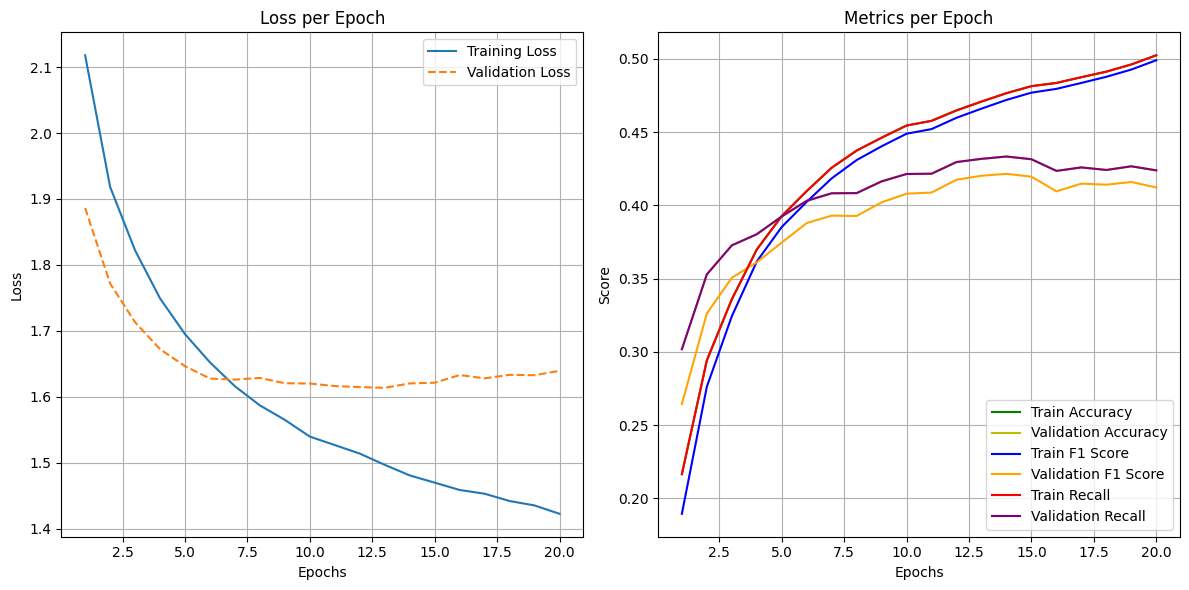

In [ ]:
from models import cross_validate,ImprovedGRUModel
import importlib
import models  
import torch
importlib.reload(models)
from utils import extract_data_and_folds,prepare_datasets,handle_pickle
import pandas as pd
import numpy as np
from visualizations import plot_DL_results


# # # Paso 1: Extraer datos y folds
# metadata_df = pd.read_csv(r'D:\Python_D\DeepLearningAudios\metadata\UrbanSound8k.csv')
# audio_directory = r'D:\Python_D\DeepLearningAudios\audio'
# features, labels, folds = extract_data_and_folds(audio_directory, metadata_df)
zcr_rmse = handle_pickle("data/all_features.pkl",mode="load")
features,folds,labels = zcr_rmse["features"],zcr_rmse["folds"],zcr_rmse["labels"]
print("Features extracted")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
    print(f"Entrenando en GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No hay GPUs disponibles. El entrenamiento se realizará en la CPU.")
    
config = {
    "learing_rate": 0.005,
    "hidden_dim1": 8,
    "hidden_dim2": 8,
    "output_dim": 10,
    "dropout_rate": 0.001,
    "weight_decay": 1e-4,
}




avg_results, train_class, valid_class, results, true_labels, pred_labels = cross_validate("BasicRNN",config,features,labels,folds,epochs = 20,device = device,verbose=2)


# Assuming 'results' is a list of dictionaries with multiple metrics as keys
metrics = [
    'train_losses', 'valid_losses', 'train_accuracies', 'train_f1_scores', 
    'train_recalls', 'valid_accuracies', 'valid_f1_scores', 'valid_recalls'
]

# Initialize dictionaries to store the mean values for each metric
mean_metrics = {metric: [] for metric in metrics}

# Assuming all folds have the same number of epochs
num_epochs = len(results[0]['train_losses'])

# Loop through each epoch
for epoch in range(num_epochs):
    for metric in metrics:
        # Collect values for this metric from all folds for the current epoch
        metric_values = [fold[metric][epoch] for fold in results]
        mean_metric = np.mean(metric_values)  # Calculate the mean of the metric values
        mean_metrics[metric].append(mean_metric)  # Append to the corresponding list

# Now, pass the mean values to the plot_DL_results function
plot_DL_results(
    mean_metrics['train_accuracies'],
    mean_metrics['valid_accuracies'],
    mean_metrics['train_losses'],
    mean_metrics['valid_losses'],
    mean_metrics['train_f1_scores'],
    mean_metrics['valid_f1_scores'],
    mean_metrics['train_recalls'],
    mean_metrics['valid_recalls']
)


### **Bias vs. varianze tradeoff : Overfitting**
The bias-variance tradeoff is a fundamental concept that describes the **balance between a model's ability to generalize and its ability to fit the training data**. Bias refers to the error introduced by simplifying assumptions in the model, while variance refers to the error introduced by the model’s sensitivity to small fluctuations in the training data. A model with high bias tends to underfit, meaning it fails to capture the underlying patterns in the data, whereas a model with high variance tends to overfit, meaning it captures not only the genuine patterns but also the noise in the training data, resulting in poor generalization to new, unseen data.

In the case of Recurrent Neural Networks (RNNs), the issue of overfitting is particularly noticeable. Overfitting occurs when the model becomes too complex and starts to **learn not only the true underlying patterns in the data** but also the noise or irrelevant details specific to the training set. This results in a model that performs well on the training data but fails to generalize to validation or test data. Overfitting is clearly observed when the training loss converges to zero over time, while the validation loss stagnates or even starts to increase after a certain number of epochs, typically around epoch 6 in our case. A similar trend is observed in the accuracy and other performance metrics, where the training accuracy continues to improve, but the validation accuracy plateaus, indicating that the model is overfitting to the training data.

To mitigate overfitting in RNNs, several techniques can be employed, including:

- **Weight Decay (L2 Regularization):** This technique penalizes large weights during training, effectively constraining the model’s complexity. It helps to prevent overfitting by discouraging the model from relying too heavily on any one feature, which could lead to overfitting.

- **Batch Normalization:** This method normalizes the activations of a layer during training, ensuring that the input to each layer remains within a certain range, which can help stabilize the training process and reduce the risk of overfitting.

- **Early Stopping:** This technique involves monitoring the performance of the model on a validation set during training and stopping the training process once the validation performance starts to deteriorate. This prevents the model from training beyond the point of optimal generalization, thus avoiding overfitting.

- **Dropout:** A regularization method that randomly drops units (along with their connections) during training, which helps prevent the model from becoming overly reliant on specific neurons, thereby improving generalization.

In our experiments with the UrbanSound8K dataset, we will begin by testing basic features, such as the frequency envelope, to evaluate its impact on model performance. Additionally, we will explore various RNN architectures, including LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Units), to determine whether these more advanced structures can help mitigate overfitting and improve model performance. 

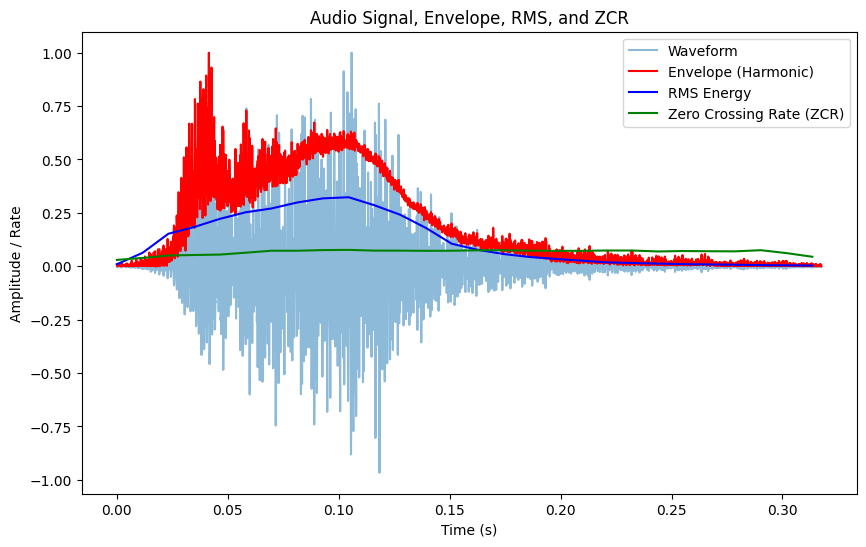

In [1]:
from visualizations import  plot_signal_and_envelope
import os
DATA_DIR = r"D:\Python_D\DeepLearningAudios"
dir_audio_example = os.path.join(DATA_DIR, "audio", "fold5", "100032-3-0-0.wav")
plot_signal_and_envelope(dir_audio_example)

Empirically, we experimented with training the model using individual low-level features, which resulted in very poor performance. The model consistently failed to surpass an average accuracy of 15%. Among the combinations of low-level features we tested, the most effective pairing was the **Zero Crossing Rate (ZCR**) and the **Root Mean Square Energy (RMSE)**, which demonstrated notably better synergy compared to other combinations. 

Datos cargados exitosamente desde data/zcr_rmse.pkl
Features extracted
Entrenando en GPU: NVIDIA GeForce RTX 3060
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 172, 8], [-1, 2, 8]]               0
       BatchNorm1d-2               [-1, 8, 172]              16
           Dropout-3               [-1, 172, 8]               0
               RNN-4  [[-1, 172, 8], [-1, 2, 8]]               0
       BatchNorm1d-5               [-1, 8, 172]              16
           Dropout-6               [-1, 172, 8]               0
            Linear-7                   [-1, 10]              90
Total params: 122
Trainable params: 122
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.29
Params size (MB): 0.00
Estimated Total Size (MB): 0.30
---------------------------------------------------------------

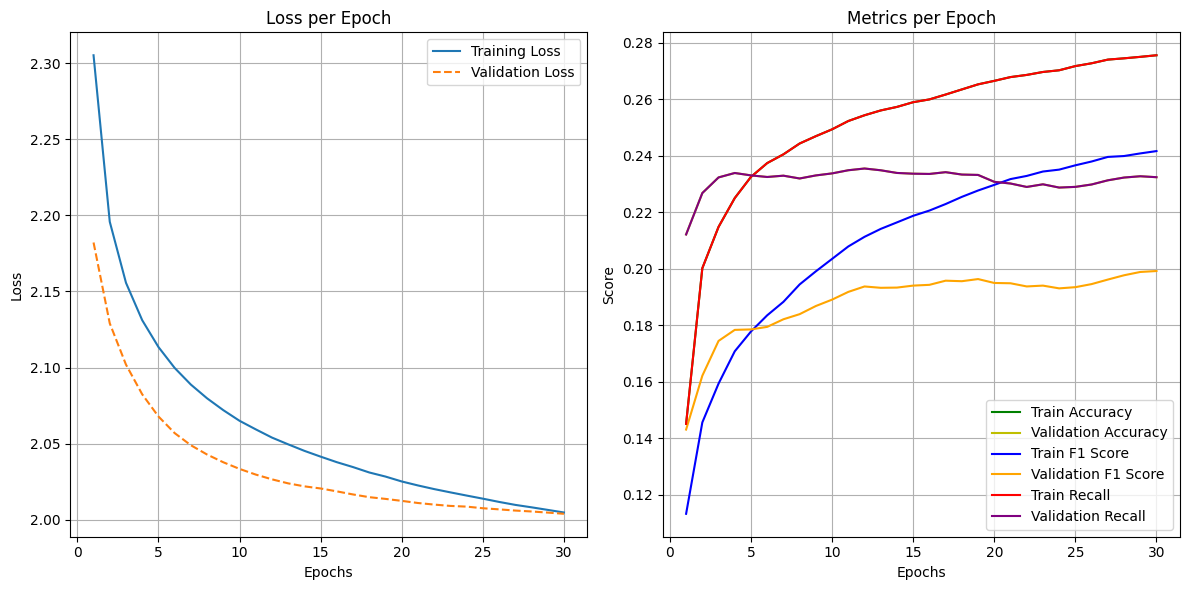

In [ ]:
from models import cross_validate,ImprovedGRUModel
import importlib
import models  
import torch
importlib.reload(models)
import models
from utils import extract_data_and_folds,prepare_datasets,handle_pickle
import pandas as pd
import numpy as np
from visualizations import plot_DL_results
# # # Fase 1: Folds, labels and data extraction : Calculated
# metadata_df = pd.read_csv(r'D:\Python_D\DeepLearningAudios\metadata\UrbanSound8k.csv')
# audio_directory = r'D:\Python_D\DeepLearningAudios\audio'
# features, labels, folds = extract_data_and_folds(audio_directory, metadata_df,feature_list = ["envelope","rmse"])
# data = {"features" : features, "labels":labels,"folds" : folds}

# # # Fase 1: Folds, labels and data extraction : Loaded
zcr_rmse = handle_pickle("data/zcr_rmse.pkl",mode="load")
features,folds,labels = zcr_rmse["features"],zcr_rmse["folds"],zcr_rmse["labels"]

print("Features extracted")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
    print(f"Entrenando en GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No hay GPUs disponibles. El entrenamiento se realizará en la CPU.")
    
config = {
    "learing_rate": 0.001,
    "hidden_dim1": 8,
    "hidden_dim2": 8,
    "output_dim": 10,
    "dropout_rate": 0.001,
    "weight_decay": 0,
}




avg_results, train_class, valid_class, results, true_labels, pred_labels = cross_validate("BasicRNN",config,features,labels,folds,epochs = 30,device = device,verbose=2)


# Assuming 'results' is a list of dictionaries with multiple metrics as keys
metrics = [
    'train_losses', 'valid_losses', 'train_accuracies', 'train_f1_scores', 
    'train_recalls', 'valid_accuracies', 'valid_f1_scores', 'valid_recalls'
]

# Initialize dictionaries to store the mean values for each metric
mean_metrics = {metric: [] for metric in metrics}

# Assuming all folds have the same number of epochs
num_epochs = len(results[0]['train_losses'])

# Loop through each epoch
for epoch in range(num_epochs):
    for metric in metrics:
        # Collect values for this metric from all folds for the current epoch
        metric_values = [fold[metric][epoch] for fold in results]
        mean_metric = np.mean(metric_values)  # Calculate the mean of the metric values
        mean_metrics[metric].append(mean_metric)  # Append to the corresponding list

# Now, pass the mean values to the plot_DL_results function
plot_DL_results(
    mean_metrics['train_accuracies'],
    mean_metrics['valid_accuracies'],
    mean_metrics['train_losses'],
    mean_metrics['valid_losses'],
    mean_metrics['train_f1_scores'],
    mean_metrics['valid_f1_scores'],
    mean_metrics['train_recalls'],
    mean_metrics['valid_recalls']
)


As previously mentioned, relying solely on low-level features to prevent overfitting results in lower prediction accuracy and greater difficulties in model convergence. Consequently, additional Recurrent Neural Network (RNN) models will be tested to improve performance and address these challenges.

### **Long Short-Term Memory(LSTM)**
Long Short-Term Memory (LSTM) networks are a specialized type of Recurrent Neural Network (RNN) designed to overcome the limitations of traditional RNNs, particularly in handling long-term dependencies. While standard RNNs suffer from issues like vanishing and exploding gradients, making it difficult for them to capture long-range dependencies in sequential data, LSTMs use a more complex architecture with gating mechanisms that allow them to selectively retain or forget information over longer periods. This makes LSTMs more effective at learning from sequences where context over longer time steps is crucial. 

Datos cargados exitosamente desde data/all_features.pkl
Features extracted
Entrenando en GPU: NVIDIA GeForce RTX 3060
{'train_losses': 1.3857040117963797, 'valid_losses': 1.3375017707193566, 'train_accuracies': 0.46175696154706897, 'train_f1_scores': 0.47696713523747303, 'train_recalls': 0.46175696154706897, 'valid_accuracies': 0.5765844800232593, 'valid_f1_scores': 0.5703522135359544, 'valid_recalls': 0.5765844800232593}


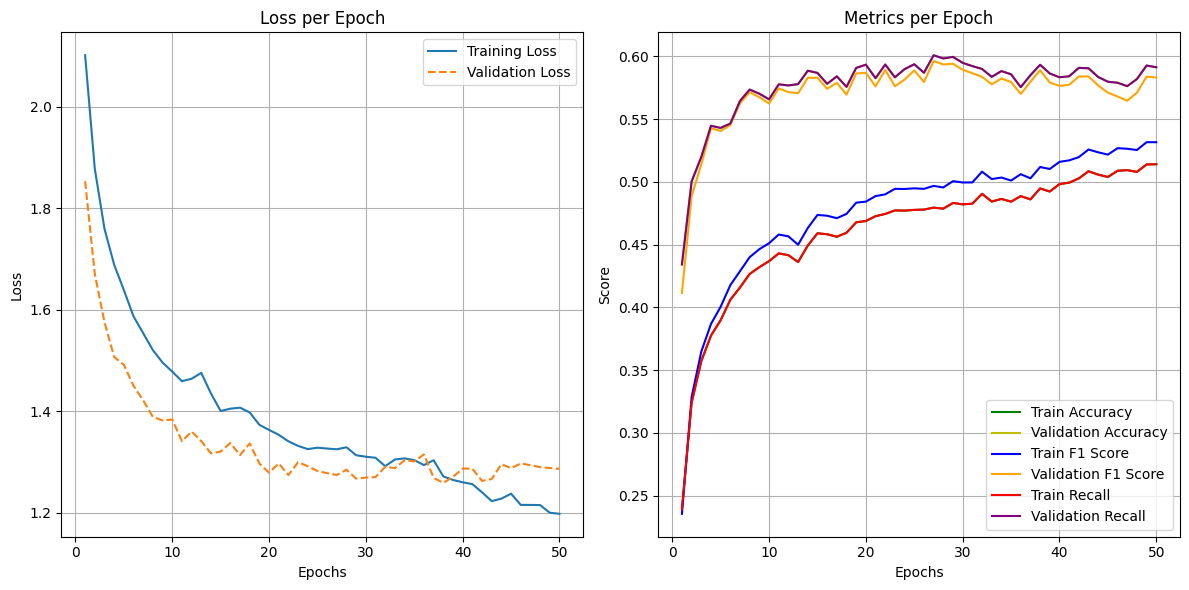

In [ ]:
from models import cross_validate,ImprovedGRUModel
import importlib
import models  
import torch
import models
importlib.reload(models)
import models
from utils import extract_data_and_folds,prepare_datasets,handle_pickle
import pandas as pd
import numpy as np
from visualizations import plot_DL_results

all_features = handle_pickle("data/all_features.pkl",mode="load")
features,folds,labels = all_features["features"],all_features["folds"],all_features["labels"]

print("Features extracted")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
    print(f"Entrenando en GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No hay GPUs disponibles. El entrenamiento se realizará en la CPU.")
    
config = {
    "learing_rate": 0.001,
    "hidden_dim1": 64,
    "output_dim": 10,
    "dropout_rate": 0.5,
    "weight_decay": 1e-4,
}



avg_results, train_class, valid_class, results, true_labels, pred_labels = cross_validate("LSTM",config,features,labels,folds,epochs = 50,device = device,verbose=2)


# Assuming 'results' is a list of dictionaries with multiple metrics as keys
metrics = [
    'train_losses', 'valid_losses', 'train_accuracies', 'train_f1_scores', 
    'train_recalls', 'valid_accuracies', 'valid_f1_scores', 'valid_recalls'
]

# Initialize dictionaries to store the mean values for each metric
mean_metrics = {metric: [] for metric in metrics}

# Assuming all folds have the same number of epochs
num_epochs = len(results[0]['train_losses'])

# Loop through each epoch
for epoch in range(num_epochs):
    for metric in metrics:
        # Collect values for this metric from all folds for the current epoch
        metric_values = [fold[metric][epoch] for fold in results]
        mean_metric = np.mean(metric_values)  # Calculate the mean of the metric values
        mean_metrics[metric].append(mean_metric)  # Append to the corresponding list

# Now, pass the mean values to the plot_DL_results function
plot_DL_results(
    mean_metrics['train_accuracies'],
    mean_metrics['valid_accuracies'],
    mean_metrics['train_losses'],
    mean_metrics['valid_losses'],
    mean_metrics['train_f1_scores'],
    mean_metrics['valid_f1_scores'],
    mean_metrics['train_recalls'],
    mean_metrics['valid_recalls']
)


A significant improvement is observed in the model's performance, particularly in validation accuracy, reaching **peak averages of 60%** in metrics such as mean accuracy, F1-score, and recall. Furthermore, the implementation of **LSTM has proven effective in mitigating overfitting** in the model. However, introducing an early stopping mechanism would be advisable in this case, as performance degradation is noticeable after epoch 30.

The observed lower validation loss can be attributed to the inclusion of harsh regularization techniques such as 0.5 Dropout and weight decay. This phenomenon is common in deep learning models, as regularization methods like L1/L2 weight regularization and Dropout are deactivated during the testing phase.

Moreover, the training loss is calculated as the average loss across all training batches within an epoch. Since the model parameters are updated throughout the training process, losses computed for the earlier batches in an epoch are generally higher compared to those computed for later batches. In contrast, the validation (or testing) loss is computed using the model's state at the end of the epoch, leading to a typically lower value.

Since Dropout is in this case set to 0.5 during training, 50% of the features are randomly set to zero to prevent overfitting. However, during testing, all features are utilized, making the model more robust and enhancing its validation accuracy.

### **Gated Recurrent Unit (GRU)**
Gated Recurrent Unit (GRU) networks are a type of Recurrent Neural Network (RNN) that offer a simpler and computationally efficient alternative to Long Short-Term Memory (LSTM) networks while retaining the ability to model sequential data effectively. GRUs address the vanishing gradient problem found in traditional RNNs by using gating mechanisms, specifically the update and reset gates, which control the flow of information through the network. Unlike LSTMs, GRUs lack a separate memory cell, combining the hidden state and cell state into a single representation. 

Datos cargados exitosamente desde data/all_features.pkl
Features extracted
Entrenando en GPU: NVIDIA GeForce RTX 3060
{'train_losses': 1.3417927894725161, 'valid_losses': 1.5209729861073533, 'train_accuracies': 0.6084291506344138, 'train_f1_scores': 0.6141444085732756, 'train_recalls': 0.6084291506344138, 'valid_accuracies': 0.5861919577549702, 'valid_f1_scores': 0.5754747512142868, 'valid_recalls': 0.5861919577549702}


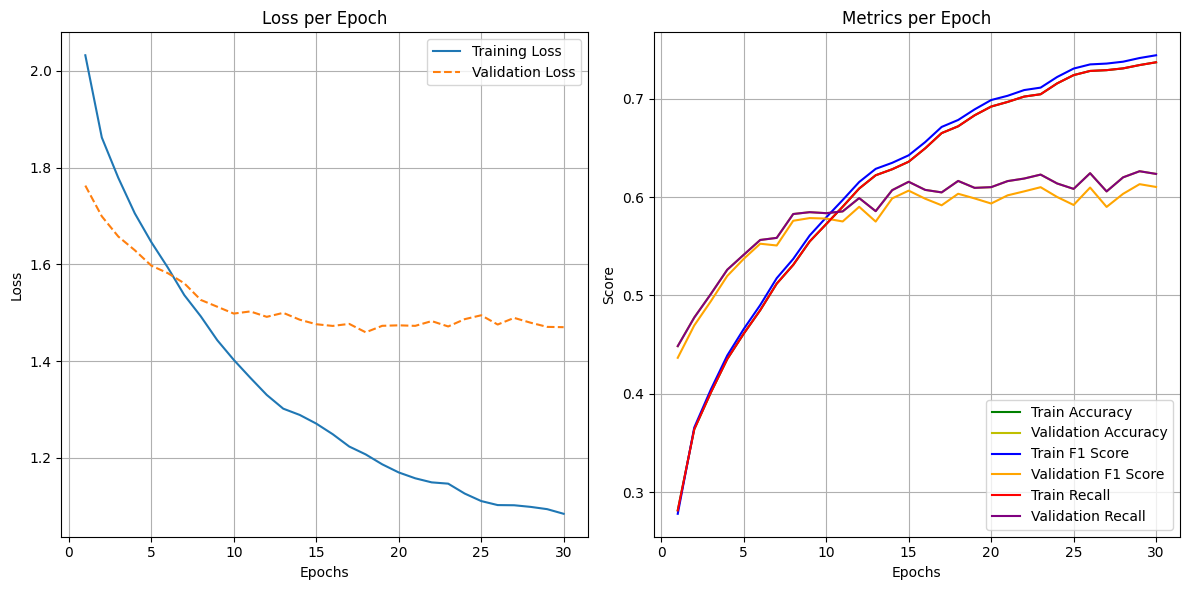

In [ ]:
from models import cross_validate,ImprovedGRUModel
import importlib
import models  
import torch
import utils
importlib.reload(utils)
import models
from utils import extract_data_and_folds,prepare_datasets,handle_pickle
import pandas as pd
import numpy as np
from visualizations import plot_DL_results

# metadata_df = pd.read_csv(r'D:\Python_D\DeepLearningAudios\metadata\UrbanSound8k.csv')
# audio_directory = r'D:\Python_D\DeepLearningAudios\audio'
# features, labels, folds = extract_data_and_folds(audio_directory, metadata_df,feature_list = ["mel_spectrogram","mfccs"])

all_features = handle_pickle("data/all_features.pkl",mode="load")
features,folds,labels = all_features["features"],all_features["folds"],all_features["labels"]
print("Features extracted")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
    print(f"Entrenando en GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No hay GPUs disponibles. El entrenamiento se realizará en la CPU.")
    
config = {
    "learing_rate": 0.001,
    "hidden_dim1": 64,
    "hidden_dim2": 64,
    "hidden_dim3": 64,
    "output_dim": 10,
    "dropout_rate": 0.3,
    "weight_decay": 1e-8,
}



avg_results, train_class, valid_class, results, true_labels, pred_labels = cross_validate("ComplexGRU",config,features,labels,folds,epochs = 30,device = device,verbose=2)


# Assuming 'results' is a list of dictionaries with multiple metrics as keys
metrics = [
    'train_losses', 'valid_losses', 'train_accuracies', 'train_f1_scores', 
    'train_recalls', 'valid_accuracies', 'valid_f1_scores', 'valid_recalls'
]

# Initialize dictionaries to store the mean values for each metric
mean_metrics = {metric: [] for metric in metrics}

# Assuming all folds have the same number of epochs
num_epochs = len(results[0]['train_losses'])

# Loop through each epoch
for epoch in range(num_epochs):
    for metric in metrics:
        # Collect values for this metric from all folds for the current epoch
        metric_values = [fold[metric][epoch] for fold in results]
        mean_metric = np.mean(metric_values)  # Calculate the mean of the metric values
        mean_metrics[metric].append(mean_metric)  # Append to the corresponding list

# Now, pass the mean values to the plot_DL_results function
plot_DL_results(
    mean_metrics['train_accuracies'],
    mean_metrics['valid_accuracies'],
    mean_metrics['train_losses'],
    mean_metrics['valid_losses'],
    mean_metrics['train_f1_scores'],
    mean_metrics['valid_f1_scores'],
    mean_metrics['train_recalls'],
    mean_metrics['valid_recalls']
)


After experimenting with various GRU neural network architectures, we achieved results comparable to those obtained with LSTM, with an average accuracy of around 60%. Additionally, it has been confirmed once again that non-basic RNN architectures effectively mitigate model overfitting. 

However, the bias-variance tradeoff remains a challenge, with factors such as dropout rates and the size of the hidden dimensions significantly impacting the results. Fine-tuning these parameters is essential to strike the right balance between underfitting and overfitting, ensuring optimal model performance.

Finally, inspired by previous literature, we plan to test a hybrid approach combining CNN and RNN models. We propose a CRNN architecture, where convolutional layers are applied before feeding data into the RNN model, aiming to leverage the strengths of both convolutional and recurrent networks.

### **Convolutional Recurrent Neural Networks(CRNN)**

In this final phase, we will integrate convolutional techniques, such as ELU activations and 1D convolutional layers, preceding the RNN layers. The aim is to evaluate whether these enhancements improve validation performance. Additionally, key parameters like dropout rates and hidden dimensions will be fine-tuned to address the bias-variance tradeoff and further optimize the model's overall effectiveness.

Datos cargados exitosamente desde data/all_features.pkl
Features extracted
Entrenando en GPU: NVIDIA GeForce RTX 3060
{'train_losses': 1.1723075147194013, 'valid_losses': 1.2418242220797366, 'train_accuracies': 0.567051748803216, 'train_f1_scores': 0.5724337465638084, 'train_recalls': 0.567051748803216, 'valid_accuracies': 0.5964248994324702, 'valid_f1_scores': 0.5874756982236398, 'valid_recalls': 0.5964248994324702}


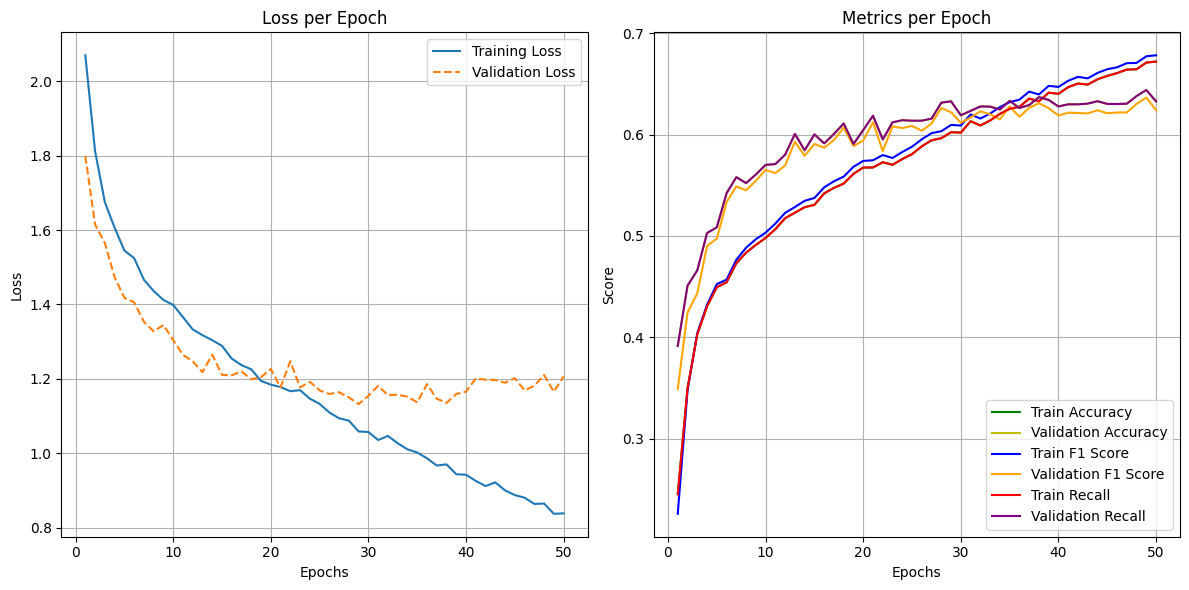

In [1]:
from models import cross_validate,ImprovedGRUModel
import importlib
import models  
import torch
import models
importlib.reload(models)
import models
from utils import extract_data_and_folds,prepare_datasets,handle_pickle
import pandas as pd
import numpy as np
from visualizations import plot_DL_results

all_features = handle_pickle("data/all_features.pkl",mode="load")
features,folds,labels = all_features["features"],all_features["folds"],all_features["labels"]

print("Features extracted")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
    print(f"Entrenando en GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No hay GPUs disponibles. El entrenamiento se realizará en la CPU.")
    
config = {
    "learing_rate": 0.001,
    "hidden_dim":32,
    "hidden_dim1": 64,
    "output_dim": 10,
    "dropout_rate": 0.3,
    "weight_decay": 1e-8,
}



avg_results, train_class, valid_class, results, true_labels, pred_labels = cross_validate("CLSTM",config,features,labels,folds,epochs = 50,device = device,verbose=2)


# Assuming 'results' is a list of dictionaries with multiple metrics as keys
metrics = [
    'train_losses', 'valid_losses', 'train_accuracies', 'train_f1_scores', 
    'train_recalls', 'valid_accuracies', 'valid_f1_scores', 'valid_recalls'
]

# Initialize dictionaries to store the mean values for each metric
mean_metrics = {metric: [] for metric in metrics}

# Assuming all folds have the same number of epochs
num_epochs = len(results[0]['train_losses'])

# Loop through each epoch
for epoch in range(num_epochs):
    for metric in metrics:
        # Collect values for this metric from all folds for the current epoch
        metric_values = [fold[metric][epoch] for fold in results]
        mean_metric = np.mean(metric_values)  # Calculate the mean of the metric values
        mean_metrics[metric].append(mean_metric)  # Append to the corresponding list

# Now, pass the mean values to the plot_DL_results function
plot_DL_results(
    mean_metrics['train_accuracies'],
    mean_metrics['valid_accuracies'],
    mean_metrics['train_losses'],
    mean_metrics['valid_losses'],
    mean_metrics['train_f1_scores'],
    mean_metrics['valid_f1_scores'],
    mean_metrics['train_recalls'],
    mean_metrics['valid_recalls']
)


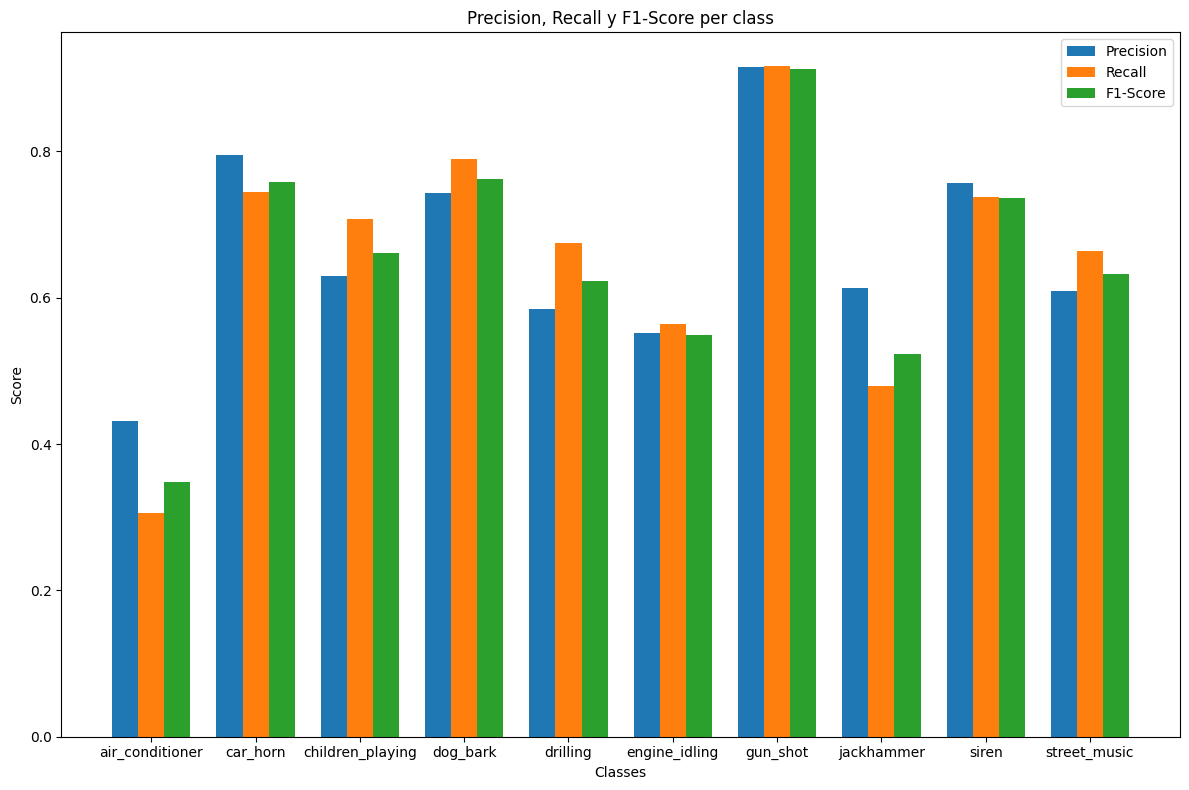

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Mapeo de clases (según el UrbanSound8K dataset)
class_names = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 
               'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 
               'siren', 'street_music']

# Inicializa un diccionario para almacenar las medias de cada clase y cada métrica
mean_class_metrics = {}

# Asumiendo que 'results' es una lista de diccionarios con las métricas de cada fold
for fold in results:
    class_metrics = fold['valid_class_metrics'][-1]  # Accede a las métricas de la última época
    
    # Itera sobre las clases (0-9)
    for class_id, metrics in class_metrics.items():
        if class_id != 'accuracy' and class_id != 'macro avg' and class_id != 'weighted avg':
            # Si la clase aún no tiene una entrada, inicializa su lista para las métricas
            if class_id not in mean_class_metrics:
                mean_class_metrics[class_id] = {'precision': [], 'recall': [], 'f1-score': []}
            
            # Agrega las métricas actuales a las listas correspondientes
            mean_class_metrics[class_id]['precision'].append(metrics['precision'])
            mean_class_metrics[class_id]['recall'].append(metrics['recall'])
            mean_class_metrics[class_id]['f1-score'].append(metrics['f1-score'])

# Ahora, calcula la media para cada clase
for class_id in mean_class_metrics:
    for metric in ['precision', 'recall', 'f1-score']:
        # Calcula la media de la métrica para esta clase a través de todos los folds
        mean_class_metrics[class_id][metric] = np.mean(mean_class_metrics[class_id][metric])

# Ahora vamos a graficar
# Extraemos los valores para el gráfico
classes = list(mean_class_metrics.keys())
class_names_for_plot = [class_names[int(class_id)] for class_id in classes]  # Mapear los nombres correctamente usando enteros
precision_values = [mean_class_metrics[class_id]['precision'] for class_id in classes]
recall_values = [mean_class_metrics[class_id]['recall'] for class_id in classes]
f1_score_values = [mean_class_metrics[class_id]['f1-score'] for class_id in classes]

# Configuramos la posición de las barras
x = np.arange(len(classes))  # El número de clases
width = 0.25  # Ancho de las barras

# Crear el gráfico de barras
fig, ax = plt.subplots(figsize=(12, 8))

bars1 = ax.bar(x - width, precision_values, width, label='Precision')
bars2 = ax.bar(x, recall_values, width, label='Recall')
bars3 = ax.bar(x + width, f1_score_values, width, label='F1-Score')

# Añadir etiquetas y título
ax.set_xlabel('Classes')
ax.set_ylabel('Score')
ax.set_title('Precision, Recall y F1-Score per class')
ax.set_xticks(x)
ax.set_xticklabels(class_names_for_plot)  # Mostrar los nombres de las clases
ax.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In the graph, we observe that the best-classified categories are **gun_shot**, **siren**, **car_horn**, and **dog_bark**. Conversely, our model struggles to classify **air_conditioner** and **jackhammer**, which aligns with observations from Justin Salomon's paper. This is reasonable, as the timbre of each pair is quite similar; for the latter pair, the presence of complex harmonic tones could be a contributing factor.

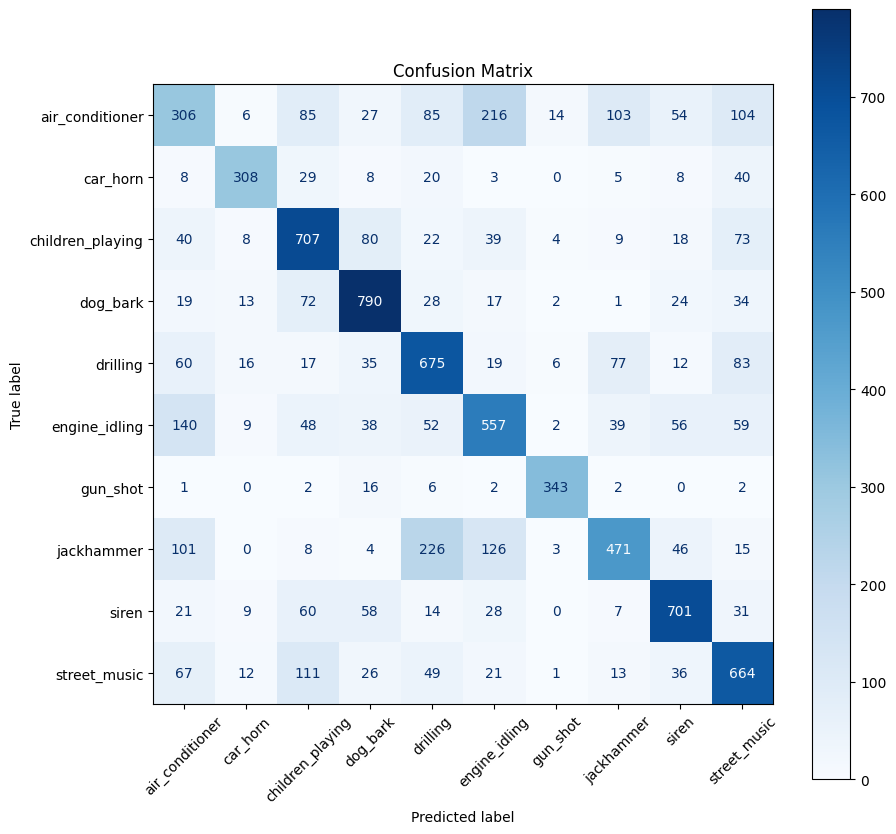

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Concatenar todas las listas dentro de true_labels y pred_labels
all_true = [label for fold_labels in true_labels for label in fold_labels]
all_pred = [label for fold_labels in pred_labels for label in fold_labels]

# Generar la matriz de confusión
conf_matrix = confusion_matrix(all_true, all_pred)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)

plt.title("Confusion Matrix")
plt.show()


## **Convolutional Neural Networks(CNN)**
The CNN method is a type of deep learning model commonly used for tasks involving visual data, such as image recognition and video analysis. It works with a hierarchical feature learning strategy, where lower layers learn simple features, while deeper layers learn complex patterns. Some of its uses include sound classification (as is the case for this project), facial rcognition, sentence classification, object detection, etc.

The way it's ususally structured is as follows:
- *input layer:* Typically a multi-dimensional array, e.g. an image represented as a grid of pixel values.
- *convolutional layers:* Layers to extract features likes edges, textures and shapes by the application of filters(kernels). The outputs are feature maps that highlight patterns in data.
- *activation function:* To introduce non-linearity after convolution. Commonly ReLu(Rectified Liner Unit).
- *Pooling layers:* Used to reduce the spatial dimensons of feature maps while retaining important features, helps make the model more efficient and reduces sensitivity to small input variations.
- *Fully connected layers:* After convolutional and pooling layers, the feature maps are flattened into a 1D vector that passes through one or more fully connected layers where evert neuron connects to every neuron in the previous layer.
- *Output layer:* The final fully connected layer which generates predictions.

CNNs learn through backpropagation and gradient descent, minimizing a loss funtion.

### **Pre-processing and feature extraction**
For the preprocessing of the CNN, we will use Mel spectrograms following the parameters outlined in Justin Salomon's paper, with the key difference of setting the number of Mel bands (**n_mels**) to 128. This adjustment aligns with procedures commonly employed in several other studies. After generating the Mel spectrograms, they will be converted to decibels (dB) for further processing.  

To handle variations in vector lengths, we will either pad the sound by repetition or truncate it if it exceeds a fixed value, set to 128 in this case. This ensures consistent input dimensions for the model while preserving essential features of the audio signals.

In [4]:
from utils import extract_features
import os
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
#extract features and labels
metadata_path = r'D:\Python_D\DeepLearningAudios\metadata\UrbanSound8K.csv'
audio_folder = r'D:\Python_D\DeepLearningAudios\audio'
metadata = pd.read_csv(metadata_path)
features, labels = extract_features(metadata, audio_folder)

#convert to NumPy arrays for model compatibility
x = np.array(features)
y = np.array(labels)

print(f"Feature array shape: {x.shape}")
print(f"Labels array shape: {y.shape}")

100%|██████████| 8732/8732 [04:15<00:00, 34.20it/s]


Feature array shape: (8732, 128, 128)
Labels array shape: (8732,)


In [ ]:
from models import prepare_splits,new_cnn_model
cnn_model = new_cnn_model()
cnn_model.summary()


d:\Python_D\DeepLearningAudios\MCII-Project\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,270,474 (12.48 MB)

 Trainable params: 3,270,154 (12.47 MB)

 Non-trainable params: 320 (1.25 KB)

### **10-fold cross-validation with CNN implemented**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

all_y_true = []
all_y_pred = []

#fold results
fold_accuracies = []
fold_losses = []

for x_train, x_val, x_test, y_train, y_val, y_test in prepare_splits(x, y, metadata):
    cnn_model = new_cnn_model(input_shape=(128, 128, 1), num_classes=len(np.unique(y)))

       # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
    )

    #training model
    cnn_model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size=64,
        epochs=15,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    #evatuation of the test set
    test_loss, test_accuracy = cnn_model.evaluate(x_test, y_test, verbose=0)
    print(f"Test accuracy: {test_accuracy:.2f}, Test loss: {test_loss:.2f}")
    fold_accuracies.append(test_accuracy)
    fold_losses.append(test_loss)

    y_pred = np.argmax(cnn_model.predict(x_test), axis=1)
    all_y_pred.extend(y_pred)
    all_y_true.extend(y_test)

cumulative_conf_matrix = confusion_matrix(all_y_true, all_y_pred)

#averages
average_accuracy = np.mean(fold_accuracies)
std_dev_accuracy = np.std(fold_accuracies)
average_loss = np.mean(fold_losses)

print("\nCumulative  Matrix: ")
print(cumulative_conf_matrix)

print(f"\nAverage Test Accuracy: {average_accuracy:.2f}")
print(f"Standard Deviation of Test Accuracy: {std_dev_accuracy:.2f}")
print(f"Average Test Loss: {average_loss:.2f}")


Cumulative  Matrix: 
[[463   0  62  18  30 204  17  99   7 100]
 [  8 307   7   4   7   4   1  13  12  66]
 [ 61   3 652  74  11  48   2   8  40 101]
 [ 44   4 125 693  16  22  14   3  51  28]
 [ 99   0  22  27 611  68  11 145   3  14]
 [177   5  58  27  19 502  16 139  21  36]
 [ 25   0  13  22   2   4 305   3   0   0]
 [120   3   1   3  56 172   3 624   0  18]
 [ 37   9 117  25  31  41   0   1 573  95]
 [ 83  21 107  14  10  18   1  15  24 707]]

Average Test Accuracy: 0.63
Standard Deviation of Test Accuracy: 0.10
Average Test Loss: 1.81


# **DeepFool Strategy**
DeepFool is an algorithm designed to identify the smallest possible changes, termed **adversarial perturbations**,that can mislead a classification model, particularly deep neural networks, into making incorrect predictions. This technique serves as a diagnostic tool, revealing the model's vulnerabilities and helping to improve its resilience against adversarial attacks.

By working iteratively, DeepFool adjusts an input progressively closer to the model's decision boundary until it crosses over, causing a misclassification. DeepFool treats the decision boundaries of the classifier as if they were linear. This simplification helps calculate the minimal changes needed to cross the boundary into a misclassification zone.

Once the adjusted input crosses the decision boundary, the algorithm stops. The cumulative changes made to the input during this process are what we call the **adversarial perturbation**. These subtle changes expose critical weaknesses in how models interpret and process data, offering valuable insights for strengthening their reliability.

In [ ]:
from foolbox.attacks import LinfDeepFoolAttack,LinfPGD,L2DeepFoolAttack
model = final_model.to(device)

# for i in range (1,11):

input_bounds = (X_train_padded.min(), X_train_padded.max())         #Creamos los límites, en este caso el minimo y máximo de nuestro conjunto de entrenamiento 

# Crear el objeto Foolbox model
fmodel = fb.PyTorchModel(model, bounds=input_bounds, device=device)

#Ejemplos que "atacaremos"
num_examples = 100
indices = np.random.choice(len(X_test_padded), num_examples, replace=False)
X_attack = torch.tensor(X_test_padded[indices], dtype=torch.float32).to(device)
print(f"Dimensiones completas X_attack: {X_attack.shape}")

y_attack = torch.tensor(y_test_numeric[indices], dtype=torch.long).to(device)
print(f"Dimensiones completas y_attack: {y_attack.shape}")

attack = LinfPGD()
# Visualizar un ejemplo exitoso
def plot_features(original, adversarial, index):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original.T, aspect='auto', origin='lower')
    plt.title(f'Original - Clase {y_attack[index].item()}')
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(adversarial.T, aspect='auto', origin='lower')
    plt.title(f'Adversarial - Clase {adversarial_preds[index].item()}')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

epsilons = [0.001,0.01,0.1]
adversarials = attack(fmodel, X_attack, y_attack,epsilons=epsilons)

adversarial_examples_list = adversarials[0]  # Lista de ejemplos adversariales por epsilon
perturbations_list = adversarials[1]         # Lista de perturbaciones por epsilon
success_flags = adversarials[2]              # Tensor de éxitos de forma [4, 100]
resultados=[]                                # Almacenar resultados 
# Iterar sobre cada epsilon y los ejemplos adversariales correspondientes
for i, epsilon in enumerate(epsilons):
    adversarial_examples = adversarial_examples_list[i]  # Tensor de forma [100, 172, 2]
    
    # Asegurar que los ejemplos adversariales estén en el dispositivo correcto ¿Porque hay que hacer esto?
    adversarial_examples = adversarial_examples.to(device)
    
    # Obtener las predicciones adversariales
    adversarial_preds = fmodel(adversarial_examples).argmax(axis=-1)  # Tensor de forma [100]
    
    # Calcular la tasa de éxito del ataque
    success = adversarial_preds != y_attack
    success_rate = success.float().mean().item()
    print(f"Tasa de éxito para epsilon={epsilon}: {success_rate * 100:.2f}%")
    resultados.append(success_rate)

resultados_percent = [r * 100 for r in resultados]


# Crear el plot
plt.figure(figsize=(8, 6))
plt.plot(epsilons , resultados_percent, marker='o', linestyle='-')
plt.title("Resultados en Porcentaje")
plt.xlabel("Epsilon ")
plt.ylabel("Efectividad del ataque (%)")
plt.grid(True)
plt.show()



# Seleccionar el índice del epsilon para visualizar (por ejemplo, el de epsilon=0.1)
epsilon_target = 0.1

# Convertir epsilons a array de NumPy si es necesario
if isinstance(epsilons, list):
    epsilons_array = np.array(epsilons)
else:
    epsilons_array = epsilons

epsilon_index = (np.abs(epsilons_array - epsilon_target)).argmin()

# Extraer los ejemplos adversariales y predicciones correspondientes al epsilon seleccionado
adversarial_examples = adversarial_examples_list[epsilon_index]  # Tensor de forma [100, 172, 2]
adversarial_examples = adversarial_examples.to(device)

# Obtener las predicciones adversariales correspondientes
adversarial_preds = fmodel(adversarial_examples).argmax(axis=-1)  # Tensor de forma [100]


# Obtener los índices de ejemplos donde el ataque tuvo éxito
success = adversarial_preds != y_attack
successful_indices = np.where(success.cpu().numpy())[0]

if len(successful_indices) > 0:
    example_idx = successful_indices[0]
    original = X_attack[example_idx].cpu().numpy()
    adversarial = adversarial_examples[example_idx].cpu().numpy()
    plot_features(original, adversarial, example_idx)
else:
    print("No hubo ataques exitosos para visualizar.")


![deepfool](images/deepfool.png)

The L2DeepFoolAttack was employed, resulting in the misclassification of 100% of the examples. However, we also sought to ascertain the epsilon level at which our model could resist adversarial attacks through the implementation of LinfPGD. In this context, epsilon represents controls how much the input is altered. 

The resulting outputs indicate that the model is susceptible to adversarial perturbations, with a considerable proportion of samples misclassified at low epsilon values.

![adversial](images/adversial.png)

# **Results and discussion**
 
In this work, we have applied deep learning techniques to classify environmental sounds. Features were extracted from the dataset, and the models were evaluated using the cross-validation methodology proposed by Salomon. The best results obtained are as follows:
\begin{array}{|c|c|c|c|}
\hline
\textbf{Model} & \textbf{Accuracy} & \textbf{F1 Score} & \textbf{Recall} \\
\hline
\text{RNN} & 0.41 & 0.39 & 0.41 \\
\text{LSTM} & 0.58 & 0.57 & 0.58 \\
\text{GRU} & 0.59 & 0.58 & 0.59 \\
\text{CLSTM} & 0.60 & 0.59 & 0.60 \\
\text{CNN} & 0.62 & 0.60 & 0.60 \\
\hline
\end{array}

As can be seen, the CNN and CLSTM models exhibit the best results, demonstrating strong predictive power and robustness when applied to unseen samples. These models effectively capture both spatial and temporal features, contributing to their superior performance. However, further improvements could be achieved by exploring more advanced methods, such as the integration of attention mechanisms and/or transformers, which have shown promise in enhancing the model's ability to focus on relevant parts of the input data. Additionally, techniques like data augmentation, including time shifting, pitch shifting, and output stretching, could improve model generalization. Training with adversarial data may also help enhance robustness, enabling the model to better handle noisy or perturbed inputs. These approaches, combined, could potentially lead to even better performance in future experiments.



# **Bibliography**
https://www.sciencedirect.com/science/article/abs/pii/S105381190400638X

https://medium.com/@jaygoyal_73697/audio-classification-of-dogs-and-cats-using-cnn-and-rnn-dcff355749e7

https://asmp-eurasipjournals.springeropen.com/articles/10.1186/s13636-020-00172-6

https://arxiv.org/abs/1702.06286

https://paginas.fe.up.pt/~tavares/downloads/publications/artigos/sensors-22-08874.pdf

https://www.mdpi.com/2076-3417/12/12/5988

https://ietresearch.onlinelibrary.wiley.com/doi/full/10.1049/iet-spr.2019.0381

https://www.tensorflow.org/tutorials/images/cnn?hl=pt-br

https://medium.com/thedeephub/convolutional-neural-networks-a-comprehensive-guide-5cc0b5eae175

https://www.researchgate.net/publication/372738035_A_Deep_Learning_Approach_for_Urban_Sound_Classification
